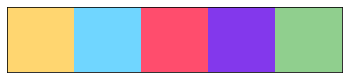

In [1]:
import os, tqdm, json, pickle, gc, zipfile, itertools, time, collections, sys, requests, schedule
import pandas as pd
import numpy as np
from dateutil import parser
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from collections import defaultdict
from datetime import datetime
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error
import catboost as cb
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.inspection import permutation_importance
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

custom_colors = ["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(custom_colors),size=1.2)
plt.tick_params(axis='both', labelsize=0, length = 0)

class CatBoostEvalMetricAMEX(object):
    
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):        
        return True

    def evaluate(self, approxes, target, weight):

        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        preds = np.array(approxes[0])
        target = np.array(target)

        score = self.amex_metric_numpy(target, preds)     

        return score, 0

    def amex_metric_numpy(self, y_true, y_pred):

        # count of positives and negatives
        n_pos = y_true.sum()
        n_neg = y_true.shape[0] - n_pos

        # sorting by descring prediction values
        indices = np.argsort(y_pred)[::-1]
        preds, target = y_pred[indices], y_true[indices]

        # filter the top 4% by cumulative row weights
        weight = 20.0 - target * 19.0
        cum_norm_weight = (weight / weight.sum()).cumsum()
        four_pct_filter = cum_norm_weight <= 0.04

        # default rate captured at 4%
        d = target[four_pct_filter].sum() / n_pos

        # weighted gini coefficient
        lorentz = (target / n_pos).cumsum()
        gini = ((lorentz - cum_norm_weight) * weight).sum()

        # max weighted gini coefficient
        gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

        # normalized weighted gini coefficient
        g = gini / gini_max

        return 0.5 * (g + d)

def amex_metric_official(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()

    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

def get_metrics(model, X_eval, y_eval):

    """ calulate metrics """

    pred = model.predict(X_eval)
    pred_prob = model.predict_proba(X_eval)[:, 1]

    d= {}

    d['accuracy'] = accuracy_score(y_eval, pred)
    d['f1'] = f1_score(y_eval, pred)
    d['auc'] = roc_auc_score(y_eval, pred_prob)

    y_true, y_predprob = y_eval.to_frame('target'), pd.Series(pred_prob, index = y_eval.index).to_frame('prediction')
    d['amex_metric_official'] = amex_metric_official(y_true, y_predprob)

    d['tp'] = ((y_eval==1)&(pred==1)).sum()
    d['tn'] = ((y_eval==0)&(pred==0)).sum()
    d['fp'] = ((y_eval==0)&(pred==1)).sum()
    d['fn'] = ((y_eval==1)&(pred==0)).sum()

    d['importances'] = ser_imp = pd.Series(dict(zip(X_eval.columns, model.feature_importances_))).sort_values(ascending = False)

    return d

def eval_catboost(X_train, y_train, X_eval, y_eval, eval_metric, seed, verbose, od_wait, params):

    """ evaluate model """

    cat_features = np.where(X_train.dtypes=='category')[0]

    if params is not None:
        params_c = params.copy()
    else:
        params_c = {}   
        params_c['iterations'] = 100
    params_c['cat_features'] = cat_features
    params_c['od_type'] = 'Iter'
    params_c['od_wait'] = od_wait  
    params_c['random_state'] = seed
    params_c['eval_metric'] = eval_metric
    params_c['verbose'] = verbose

    model = cb.CatBoostClassifier(**params_c)
    model.fit(X_train, y_train, eval_set = (X_eval, y_eval))    
    best_iter = model.best_iteration_
    return model, best_iter, get_metrics(model, X_eval, y_eval) 

def get_catboost_eval_results(X_train, y_train, X_eval, y_eval):

    """ feature selection and eval results """

    i=1
    while True:

        print('> iter#{}. n_features: {}'.format(i, X_train.shape[1]))

        model, best_iter, d_eval_results = eval_catboost(X_train, y_train, X_eval, y_eval,verbose=1)

        mask = model.feature_importances_>0

        if np.all(mask):
            break
        else:
            best_features = X_train.columns[mask]
            X_train, X_eval = X_train[best_features], X_eval[best_features]
            i+=1
    i = 1       
    while True:

        L_perm_imp = []
        for _ in tqdm.tqdm(range(10)):
            d_perm_imp = permutation_importance(model, X_eval, y_eval, scoring='roc_auc', n_jobs=-1, n_repeats = 1, random_state = _)    
            L_perm_imp.append(d_perm_imp['importances_mean'])
        mean_perm_imp = np.c_[L_perm_imp].mean(0)

        mask = mean_perm_imp>0

        if np.all(mask):
            break
        else:
            best_features = X_train.columns[mask]
            X_train, X_eval = X_train[best_features], X_eval[best_features]
            model, best_iter, d_eval_results = eval_catboost(X_train, y_train, X_eval, y_eval,verbose=0)
            i+=1

    return {
        'iterations':best_iter,        
        'eval_results':d_eval_results
    }

In [2]:
# dir with data
PATH_TO_DATA= 'data'


# seed
SEED = 13

# target key
TARGET_KEY='target'

# customer id key
ID_KEY = 'customer_ID'

DATE_KEY = 'S_2'

# split
TEST_SIZE = .1

# percentiles (10)
PS = np.linspace(2.5, 97.5, 10)

# batch size
BATCH_SIZE = 1000

DEFAULT_VALUE = -999

In [3]:
# target
y = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_labels.csv')).set_index(ID_KEY)['target']

# train data
df_train = pd.read_feather(os.path.join(PATH_TO_DATA, 'train_data.ftr'))

# .drop(TARGET_KEY, 1)
# drop target, order 
df_train = df_train.set_index(ID_KEY).loc[y.index].reset_index()

In [4]:
id_values = df_train[ID_KEY].value_counts()

In [5]:
id2use = id_values[:10000].index

df_train=df_train[df_train[ID_KEY].isin(id2use)]
y= y.loc[id2use]

In [6]:
df_train = pd.concat([
    df_train,
    pd.concat([
        df_train[DATE_KEY].map(lambda row: row.timestamp()).to_frame('timestamp'),
        df_train[DATE_KEY].dt.year.to_frame('year'),
        df_train[DATE_KEY].dt.month.to_frame('month'),
        df_train[DATE_KEY].dt.day.to_frame('day'),
        df_train[DATE_KEY].dt.weekday.to_frame('weekday')
    ], 1)
], 1)

In [10]:
# categories
CAT_FEATURES = [
    'D_63', 'D_64', 'D_66', 'D_68', 'B_30', 'B_38', 'D_114', 'D_116',
    'D_117', 'D_120', 'D_126'
]

# numbers
NUM_FEATURES = [
    'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43', 'D_44', 'B_4',
    'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'D_49', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51',
    'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'D_53', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7',
    'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60',
    'D_61', 'B_15', 'S_11', 'D_62', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'S_12',
    'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'D_73', 'P_4',
    'D_74', 'D_75', 'D_76', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'R_9', 'S_16',
    'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'D_82', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14',
    'R_15', 'D_84', 'R_16', 'B_29', 'S_18', 'D_86', 'D_87', 'R_17', 'R_18', 'D_88', 'B_31', 'S_19', 'R_19',
    'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_24',
    'R_25', 'D_96', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106',
    'D_107',    'B_36', 'B_37', 'R_26', 'R_27', 'D_108', 'D_109', 'D_110', 'D_111', 'B_39', 'D_112', 'B_40',
    'S_27','D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 'D_128',
    'D_129', 'B_41', 'B_42', 'D_130', 'D_131', 'D_132', 'D_133', 'R_28', 'D_134', 'D_135', 'D_136', 'D_137',
    'D_138','D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145'
]

TIME_FEATURES = ['timestamp', 'year','month','day','weekday']

In [8]:
def add_rows(subdf, max_group_size, num_features):
    ''' pad data for customer to max records size'''
    size = subdf.shape[0]    
    df_add = pd.DataFrame(np.full((max_group_size-size, len(num_features)), np.nan), columns = num_features)    
    return df_add

def flatten_customer_data(subdf, subdf_pad, id, num_features, cat_features):

    # id and count
    d = {ID_KEY:id, 'count':len(subdf)}

    # categories
    d.update(subdf.iloc[-1][cat_features])

    # numbers
    for key in num_features:
        
        # padded
        arr_pad = subdf_pad[key].values

        # raw
        arr = subdf[key].values  
        # notnull
        arr_notna = arr[pd.notnull(arr)]
        
        # values in time
        for i, v in enumerate(arr_pad):
            d[f'{key}__ts_{i+1}'] = v
        # ranked values
        for i, v in enumerate(np.sort(arr_pad)):
            d[f'{key}__rank_{i+1}'] = v

        # aggregations
        if len(arr_notna)!=0:
            d[f'{key}__min'] = np.min(arr_notna)
            d[f'{key}__max'] = np.max(arr_notna)
            d[f'{key}__std'] = np.std(arr_notna)     
            # d[f'{key}_skew'] = stats.skew(arr_notna)  
            # d[f'{key}_kurtosis'] = stats.kurtosis(arr_notna)  
        else:
            d[f'{key}__min'] = np.nan
            d[f'{key}__max'] = np.nan
            d[f'{key}__std'] = np.nan
            # d[f'{key}_skew'] = np.nan
            # d[f'{key}_kurtosis'] = np.nan

        d[f'{key}__first'] = arr[0]
        d[f'{key}__last'] = arr[-1]

        d[f'{key}__nan_rate'] = pd.isnull(arr).mean()
        
        del arr, arr_pad, arr_notna

    return d

def flatten_customer_history(subdf_pad):
    
    # customer description
    row = {}

    # value with time
    for i in range(subdf_pad.shape[0]):
        d = subdf_pad.iloc[i].to_dict()
        for k, v in d.items():
            new_k = f'{k}__ts_{i+1}'
            row[new_k] = v
    
    # value with rank
    subdf_pad_num = subdf_pad[NUM_FEATURES]
    for i in range(subdf_pad_num.shape[1]):
        k = subdf_pad_num.columns[i]
        values_sorted = np.sort(subdf_pad_num.iloc[:, i])
        for j, v in enumerate(values_sorted):
            new_k = f'{k}__rank_{j+1}'
            row[new_k] = v

    return row

In [9]:
target = df_train[TARGET_KEY]

# clip outliers
for i, key in enumerate(NUM_FEATURES):
    
    ser= df_train[key]

    corr_abs = ser.to_frame().corrwith(target).abs().iloc[0]
    
    q1,q3=ser.quantile([.25,.95])
    iqr =q3-q1
    corr_abs_clipped= ser.clip(q1,q3).to_frame().corrwith(target).abs().iloc[0]

    if corr_abs_clipped>corr_abs:
        df_train[key]=df_train[key].clip(q1,q3)
        print('ITER {}/{}. {} -> CLIPPED'.format(i+1, len(NUM_FEATURES), key))
    else:
        print('ITER {}/{}. {} -> RAW'.format(i+1, len(NUM_FEATURES),key))

ITER 1/177. P_2 -> RAW
ITER 2/177. D_39 -> RAW
ITER 3/177. B_1 -> CLIPPED
ITER 4/177. B_2 -> RAW
ITER 5/177. R_1 -> CLIPPED
ITER 6/177. S_3 -> CLIPPED
ITER 7/177. D_41 -> CLIPPED
ITER 8/177. B_3 -> CLIPPED
ITER 9/177. D_42 -> CLIPPED
ITER 10/177. D_43 -> CLIPPED
ITER 11/177. D_44 -> CLIPPED
ITER 12/177. B_4 -> CLIPPED
ITER 13/177. D_45 -> CLIPPED
ITER 14/177. B_5 -> CLIPPED
ITER 15/177. R_2 -> RAW
ITER 16/177. D_46 -> CLIPPED
ITER 17/177. D_47 -> RAW
ITER 18/177. D_48 -> CLIPPED
ITER 19/177. D_49 -> CLIPPED
ITER 20/177. B_6 -> CLIPPED
ITER 21/177. B_7 -> CLIPPED
ITER 22/177. B_8 -> CLIPPED
ITER 23/177. D_50 -> CLIPPED
ITER 24/177. D_51 -> CLIPPED
ITER 25/177. B_9 -> CLIPPED
ITER 26/177. R_3 -> RAW
ITER 27/177. D_52 -> CLIPPED
ITER 28/177. P_3 -> RAW
ITER 29/177. B_10 -> CLIPPED
ITER 30/177. D_53 -> CLIPPED
ITER 31/177. S_5 -> CLIPPED
ITER 32/177. B_11 -> CLIPPED
ITER 33/177. S_6 -> RAW
ITER 34/177. D_54 -> RAW
ITER 35/177. R_4 -> RAW
ITER 36/177. S_7 -> CLIPPED
ITER 37/177. B_12 -> CLI

In [8]:
cat_features_nunique_by_customer = df_train[[ID_KEY]+CAT_FEATURES].astype('str').groupby(ID_KEY).nunique()

In [9]:
cat_features_nunique_by_customer.nunique()

D_63     6
D_64     5
D_66     3
D_68     6
B_30     4
B_38     7
D_114    3
D_116    3
D_117    6
D_120    3
D_126    4
dtype: int64

In [10]:
# aggregations

lambda_diff_mean = lambda x: x.diff().mean()
lambda_diff_mean.__name__ = 'diff_mean'
lambda_diff_max = lambda x: x.diff().max()
lambda_diff_max.__name__ = 'diff_max'
lambda_diff_min = lambda x: x.diff().min()
lambda_diff_min.__name__ = 'diff_min'

lambda_nan_rate = lambda x: pd.isnull(x).mean()
lambda_nan_rate.__name__ = 'nan_rate'

lambda_list = lambda x: list(x)
lambda_list.__name__ = 'list'

lambda_list_sorted = lambda x: sorted(list(x))
lambda_list_sorted.__name__ = 'list_sorted'

lambda_most_frequent = lambda x: x.value_counts().idxmax()
lambda_most_frequent.__name__ = 'most_frequent'

In [15]:
# numbers
for agg_key in tqdm.tqdm(NUM_FEATURES):
     df_agg = df_train\
          .groupby(ID_KEY)\
          [agg_key]\
          .agg({'mean','min','max', 'std', 'mad', 'first','last',\
               stats.skew, stats.kurtosis,\
               lambda_diff_mean, lambda_diff_max, lambda_diff_min,
               lambda_nan_rate,\
               lambda_list, lambda_list_sorted\
          })\
          .add_prefix(f'{agg_key}__')
     df_agg.to_pickle(f'features_v2/{agg_key}.pickle')
     del df_agg

# categories
for agg_key in tqdm.tqdm(CAT_FEATURES):
    df_agg = df_train\
        .groupby(ID_KEY)\
        [agg_key]\
        .agg({'nunique', 'first','last',\
              lambda_most_frequent\
        })\
        .add_prefix(f'{agg_key}__')
    df_agg.to_pickle(f'features_v2/{agg_key}.pickle')
    del df_agg

# aggregate by year
df_agg = df_train.groupby([ID_KEY, 'year'])[NUM_FEATURES].mean().reset_index()
rows = []
for id, subdf in tqdm.tqdm(df_agg.groupby(ID_KEY)):
    d = {ID_KEY:id}  
    for i in range(len(subdf)):
        row = subdf.iloc[i]
        suffix = 'year_{:.0f}'.format(row['year'])
        for k, v in row.iloc[2:].to_dict().items():
            d[f'{k}__{suffix}'] = v
    rows.append(d)
    del d
df_agg_by_year = pd.DataFrame.from_records(rows).set_index(ID_KEY)
df_agg_by_year.to_pickle('features_v2/df_agg_by_year.pickle')
del df_agg_by_year

100%|██████████| 10000/10000 [00:07<00:00, 1374.63it/s]


In [3]:
PATH_TO_DIR = 'features_v2'

# collect index and columns
s_index, s_columns = set(), set()
for filename in tqdm.tqdm(os.listdir(PATH_TO_DIR)):
    pth= os.path.join(PATH_TO_DIR, filename)
    with open(pth, 'rb') as f:
        subdf = pickle.load(f) 
    s_index.update(set(subdf.index.tolist()))
    s_columns.update(set(subdf.columns.tolist()))
    del subdf

100%|██████████| 189/189 [00:05<00:00, 34.05it/s]


In [4]:
# fill table with features
df_features= pd.DataFrame(index= s_index,columns =s_columns)
for filename in tqdm.tqdm(os.listdir(PATH_TO_DIR)):
    pth= os.path.join(PATH_TO_DIR, filename)
    with open(pth, 'rb') as f:
        subdf = pickle.load(f) 
    df_features.loc[subdf.index,subdf.columns] = subdf.values
    del subdf

100%|██████████| 189/189 [00:08<00:00, 22.84it/s]


In [5]:
# transform collected lists ({key}__ts_1, ... , {key}__ts_13))
list_keys= df_features.columns[df_features.columns.str.contains('list')]
index= df_features.index
for key in tqdm.tqdm_notebook(list_keys):  
    if 'sorted' in key:
        suffix = 'rank'
    else:
        suffix = 'ts'
    for i in tqdm.tqdm_notebook(range(len(index))):
        row= df_features.iloc[i][key]
        k= key.split('__')[0]
        d= {}
        for j, v in enumerate(row):
            df_features.loc[index[i], f'{k}__{suffix}_{j+1}'] = v
    df_features.drop(key, 1, inplace= True)    

  0%|          | 0/354 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
df_features.to_pickle('df_features.pickle')

In [7]:
df_features.head()

,B_15__mad,D_130__min,B_29__mean,R_19__diff_max,D_48__max,P_2__year_2017,B_41__nan_rate,S_18__year_2017,D_141__diff_mean,D_62__last,...,D_73__ts_4,D_73__ts_5,D_73__ts_6,D_73__ts_7,D_73__ts_8,D_73__ts_9,D_73__ts_10,D_73__ts_11,D_73__ts_12,D_73__ts_13
a0841668a5e8e7c1a2ef1fe315f0133ed698e571f5f5e6c4863570c784c4a381,0.002495,1.000977,NaN,0.00753,0.173462,0.93457,0.0,0.006367,0.0,0.481201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a0fb9fd39c894bc6da21e4066a2b85d8ae96d44f42b9ce8f9b5ab1e623a6f082,0.042969,0.000674,NaN,0.005661,0.765625,0.775879,0.0,0.00491,0.000316,0.03299,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a79ee956611a6b13ccee0f5ee133e4fe608252318b5521fbffcae60d54503aa4,0.002956,0.001911,NaN,0.007484,0.469727,0.747559,0.0,0.005878,0.000062,0.372314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a0fbb0275f93f4c178f9fb4cb2bff74a0e52866dcf435c0f55fbaaa14787e812,0.002361,0.001043,NaN,0.00507,0.884277,0.655273,0.0,0.003731,-0.000163,0.034973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a20fdde9d9118126db976ae12e79dcd3f1f54e226c42f9fd7816c2b6e7a1628a,0.002413,0.000316,NaN,0.009216,0.938965,0.139038,0.0,0.004528,0.000188,0.03299,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
assert df_features.shape[0]==10000

In [11]:
dd_keys = defaultdict(list)
for key in tqdm.tqdm(df_features.columns):
    k = key.split('__')[0]
    dd_keys[k].append(key)
all_keys = []
for k, v in dd_keys.items():
    all_keys.extend(np.sort(v))
df_features = df_features[all_keys]

cat_features= []
for key in CAT_FEATURES:
    cat_features.extend([f'{key}__first', f'{key}__last', f'{key}__most_frequent'])
num_features = df_features.drop(cat_features, 1).columns.tolist()

assert len(cat_features)+len(num_features) == df_features.shape[1]

100%|██████████| 7301/7301 [00:00<00:00, 1220364.78it/s]


In [13]:
label_encoder = LabelEncoder()
for key in tqdm.tqdm(cat_features):
    arr = df_features[key].astype('str').astype('category').values
    df_features[key] = label_encoder.fit_transform(arr).flatten()
    del arr

scaler = MinMaxScaler()
for key in tqdm.tqdm(num_features):
    arr = df_features[key].replace({-np.inf:np.nan, np.inf:np.nan}).values.reshape(-1,1)
    df_features[key] = scaler.fit_transform(arr).flatten()
    del arr
    
df_features.fillna(-9999, inplace = True)

100%|██████████| 7268/7268 [13:10<00:00,  9.19it/s] 


In [14]:
df_features = df_features.replace({-9999:-1})
df_features[cat_features] = df_features[cat_features].astype('category')

In [15]:
X = df_features.copy()
del df_features
gc.collect()

y = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_labels.csv')).set_index(ID_KEY)['target'].loc[X.index]


In [18]:
with open('Xy.pickle', 'wb') as f:
    pickle.dump((X, y), f)

In [44]:
with open('Xy.pickle', 'rb') as f:
    X, y = pickle.load(f)

In [45]:
# X_train, X_holdout, y_train, y_holdout = train_test_split(
#     X, y,
#     test_size=TEST_SIZE,
#     stratify = y,
#     shuffle= True,
#     random_state = SEED
# )

X_train, X_eval, y_train, y_eval = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify = y,
    shuffle= True,
    random_state = SEED
)

In [46]:
del X, y
gc.collect()

245283

In [47]:
def amex_metric_numpy(y_true, y_pred):

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

In [49]:
# total boosting iterations
ITERATIONS= 100
# early stopping detector
OD_WAIT = 20
# total permutation iterations
N_PERM_ITERATIONS = 10
# permutation repeats
N_REPEATS = 100

In [50]:
features, scores = [], []

while True:    

    params = {
    'iterations':ITERATIONS,
    'od_type':'Iter', 'od_wait':OD_WAIT, 
    'eval_metric':CatBoostEvalMetricAMEX(),
    'cat_features':np.where(X_train.dtypes=='category')[0],
    'use_best_model':True,
    'verbose':1
    }

    model = cb.CatBoostClassifier(**params)

    model.fit(X_train, y_train, eval_set=(X_eval, y_eval))
    
    features.append(X_train.columns)
    scores.append(amex_metric_numpy(y_eval, model.predict_proba(X_eval)[:, 1]))

    mask = model.feature_importances_>0

    if np.all(mask):
        break
    else:
        X_train, X_eval = X_train.loc[:, mask], X_eval.loc[:, mask] 

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.148459
0:	learn: 0.6462765	test: 0.6184656	best: 0.6184656 (0)	total: 760ms	remaining: 1m 15s
1:	learn: 0.7209231	test: 0.6777143	best: 0.6777143 (1)	total: 1.38s	remaining: 1m 7s
2:	learn: 0.7433829	test: 0.7138738	best: 0.7138738 (2)	total: 2.01s	remaining: 1m 4s
3:	learn: 0.7547598	test: 0.7448284	best: 0.7448284 (3)	total: 2.65s	remaining: 1m 3s
4:	learn: 0.7679176	test: 0.7520300	best: 0.7520300 (4)	total: 3.29s	remaining: 1m 2s
5:	learn: 0.7735631	test: 0.7639051	best: 0.7639051 (5)	total: 3.95s	remaining: 1m 1s
6:	learn: 0.7879593	test: 0.7675910	best: 0.7675910 (6)	total: 4.64s	remaining: 1m 1s
7:	learn: 0.7957311	test: 0.7643654	best: 0.7675910 (6)	total: 5.35s	remaining: 1m 1s
8:	learn: 0.7991093	test: 0.7718033	best: 0.7718033 (8)	total: 5.99s	remaining: 1m
9:	learn: 0.8039712	test: 0.7701848	best: 0.7718033 (8)	total: 6.6s	remaining: 59.4s
10:	learn: 0.8075060	test: 0.7700225	best: 0.7718033 (8)	total: 7.2s	remaining: 58.3s
11:	learn: 0.8112854	test: 

In [67]:
ser_imp = pd.Series(dict(zip(X_train.columns, model.feature_importances_))).sort_values(ascending = False)

In [53]:
all_features = X_train.columns
drop = []
for i in range(len(all_features)):
    for j in range(i+1, len(all_features)):
        x1 = X_train.iloc[:, i]
        x2= X_train.iloc[:, j]
        if (x1==x2).all():
            drop.append(X_train.columns[i])

In [52]:
scores

[0.815064651550598,
 0.8021540119721106,
 0.8271755545213333,
 0.806773556112333,
 0.809697290690073,
 0.8063807072964989,
 0.8094925155056399,
 0.8191718946840669]

In [57]:
X_train = X_train.drop(drop, 1)
X_eval = X_eval.drop(drop, 1)

In [63]:
ITERATIONS=20000
OD_WAIT=5000

params = {
    'iterations':ITERATIONS,
    'od_type':'Iter', 'od_wait':OD_WAIT, 
    'eval_metric':CatBoostEvalMetricAMEX(),
    'cat_features':np.where(X_train.dtypes=='category')[0],
    'use_best_model':True,
    'verbose':1
    }

model = cb.CatBoostClassifier(**params)

model.fit(X_train, y_train, eval_set=(X_eval, y_eval))

score = amex_metric_numpy(y_eval, model.predict_proba(X_eval)[:, 1])

Learning rate set to 0.014814
0:	learn: 0.6992081	test: 0.6646114	best: 0.6646114 (0)	total: 60.7ms	remaining: 20m 13s
1:	learn: 0.7298180	test: 0.7265482	best: 0.7265482 (1)	total: 71.7ms	remaining: 11m 56s
2:	learn: 0.7449495	test: 0.7588851	best: 0.7588851 (2)	total: 83.9ms	remaining: 9m 19s
3:	learn: 0.7559306	test: 0.7527240	best: 0.7588851 (2)	total: 96.2ms	remaining: 8m
4:	learn: 0.7612792	test: 0.7660893	best: 0.7660893 (4)	total: 109ms	remaining: 7m 16s
5:	learn: 0.7643676	test: 0.7623689	best: 0.7660893 (4)	total: 124ms	remaining: 6m 52s
6:	learn: 0.7655174	test: 0.7651648	best: 0.7660893 (4)	total: 136ms	remaining: 6m 27s
7:	learn: 0.7681949	test: 0.7610291	best: 0.7660893 (4)	total: 148ms	remaining: 6m 10s
8:	learn: 0.7661988	test: 0.7563247	best: 0.7660893 (4)	total: 161ms	remaining: 5m 58s
9:	learn: 0.7685989	test: 0.7543592	best: 0.7660893 (4)	total: 174ms	remaining: 5m 47s
10:	learn: 0.7696574	test: 0.7570698	best: 0.7660893 (4)	total: 187ms	remaining: 5m 40s
11:	learn:

In [65]:
print('BEST SCORE: {}'.format(score))

BEST SCORE: 0.8199595288013425


In [68]:
for i, (k, v) in enumerate(ser_imp.items()):
    print('{}. FEATURE:{}, IMPORTANCE:{}'.format(i+1, k, v))

1. FEATURE:P_2__last, IMPORTANCE:4.8212602675164815
2. FEATURE:P_2__ts_13, IMPORTANCE:2.735825410968237
3. FEATURE:B_11__last, IMPORTANCE:2.3312049217019304
4. FEATURE:B_4__ts_13, IMPORTANCE:2.2876729906242517
5. FEATURE:B_2__ts_13, IMPORTANCE:2.2147722933813596
6. FEATURE:D_44__last, IMPORTANCE:2.067047183102447
7. FEATURE:S_3__max, IMPORTANCE:1.9452814239952505
8. FEATURE:B_9__ts_13, IMPORTANCE:1.9027495108226253
9. FEATURE:R_1__ts_13, IMPORTANCE:1.8442550771144166
10. FEATURE:D_52__ts_4, IMPORTANCE:1.7956758113512803
11. FEATURE:D_39__last, IMPORTANCE:1.754344474839753
12. FEATURE:D_41__diff_mean, IMPORTANCE:1.7468130906139703
13. FEATURE:P_2__rank_3, IMPORTANCE:1.7068020009600182
14. FEATURE:S_7__last, IMPORTANCE:1.6871294232375107
15. FEATURE:S_25__std, IMPORTANCE:1.6593278446975148
16. FEATURE:S_11__ts_6, IMPORTANCE:1.644678665337133
17. FEATURE:B_4__diff_mean, IMPORTANCE:1.6388502420055509
18. FEATURE:B_3__diff_mean, IMPORTANCE:1.6329089014096676
19. FEATURE:D_48__last, IMPORTAN

In [ ]:
# import optuna

# def objective(trial):
    
#     param = {
#         "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
#         "depth": trial.suggest_int("depth", 1, 12),
#         "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "bootstrap_type": trial.suggest_categorical(
#             "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
#         ),
#     }

#     if param["bootstrap_type"] == "Bayesian":
#         param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#     elif param["bootstrap_type"] == "Bernoulli":
#         param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

#     gbm = cb.CatBoostClassifier(**param)

#     gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

#     preds = gbm.predict(valid_x)
#     pred_labels = np.rint(preds)
#     accuracy = accuracy_score(valid_y, pred_labels)
#     return accuracy



# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100, timeout=600)